# use Logistic Regression to run sentiment analysis of tweets  
Author: Xuebing-2023
in this notebook, I will
1. Preprocess the tweets
2. train the logstic regression model
3. predict the new sentence
4. test the naive bayes model
5. do some error analysis

In [158]:
import nltk
import string
import numpy as np
import re


In [159]:
#get the positive and negative tweets
all_positive_tweets = nltk.corpus.twitter_samples.strings('positive_tweets.json')
all_negative_tweets = nltk.corpus.twitter_samples.strings('negative_tweets.json')
print('all_positive_tweets: ',len(all_positive_tweets),'\nall_negative_tweets: ',len(all_positive_tweets))

all_positive_tweets:  5000 
all_negative_tweets:  5000


In [167]:
#split data into train and test sets use 0.8/0.2 rule
train_x = all_positive_tweets[:4000] + all_negative_tweets[:4000]
test_x = all_positive_tweets[4000:] + all_negative_tweets[4000:]

train_y = np.append(np.ones((4000,1)),np.zeros((4000,1)), axis = 0)
test_y = np.append(np.ones((1000,1)), np.zeros((1000,1)), axis = 0)
print(len(train_x), len(train_y), len(test_x), len(test_y))

8000 8000 2000 2000


In [168]:
train_y.shape

(8000, 1)

## preprocessing the sentence
1. lowercase
2. remove url
3. remove stop words
4. stemming

In [16]:
def process_tweet(tweet):
    '''
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet
    '''
    #need the package re, string, numpy and nltk
    stemmer = nltk.stem.PorterStemmer()
    stopwords_english = nltk.corpus.stopwords.words('english')
    tokenizer = nltk.tokenize.TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    # remove hashtags
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tweet_tokens = tokenizer.tokenize(tweet)
    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

In [17]:
#example:
custom_tweet = "RT @Twitter @chapagain Hello There! Have a great day. :) #good #morning http://chapagain.com.np"
print(process_tweet(custom_tweet))

['hello', 'great', 'day', ':)', 'good', 'morn']


In [18]:
#example:
first_tweet = train_x[0]
print(process_tweet(first_tweet))

['followfriday', 'top', 'engag', 'member', 'commun', 'week', ':)']


## sigmoid function
1. the core of logistic regression: $ h(z) = \frac{1}{1+\exp^{-z}} $

In [20]:
def sigmoid(z): 
    '''
    Input:
        z: is the input (can be a scalar or an array)
    Output:
        h: the sigmoid of z
    '''
    # calculate the sigmoid of z
    h = 1/(1+np.exp(-z))
    
    return h

In [22]:
# example:
a = np.array([1,0,2,3])
print('an array: ', sigmoid(a))
b = 3
print('a scalar: ', sigmoid(b))

an array:  [0.73105858 0.5        0.88079708 0.95257413]
a scalar:  0.9525741268224334


# Logistic: regression + sigmoid function
1. Regression: $z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$
    - the $\theta$ values are "weights", with the 'w' vector.
> calculation: $J = \frac{-1}{m} \times \left(\mathbf{y}^T \cdot log(\mathbf{h}) + \mathbf{(1-y)}^T \cdot log(\mathbf{1-h}) \right)$

2. Logistic regression: $ h(z) = \frac{1}{1+\exp^{-z}}$
    - 'z' as the 'logits'.
    
# Cost function(all dp), loss function(single dp) and Gradient
1. cost function: $J(\theta) = -\frac{1}{m} \sum_{i=1}^m y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)})) $
    - $m$ is the number of training examples
    - $y^{(i)}$ is the actual label of training example 'i'.
    - $h(z^{(i)})$ is the model's prediction for the training example 'i'.
    
2. loss function: $ Loss = -1 \times \left( y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)})) \right)$   
    - All the $h$ values are between 0 and 1, so the logs will be negative. That is the reason for the factor of -1 applied to the sum of the two loss terms.
    - when the model predicts 1 ($h(z(\theta)) = 1$) and the label 'y' is also 1, the loss for that training example is 0. 
    - when the model predicts 0 ($h(z(\theta)) = 0$) and the actual label is also 0, the loss for that training example is 0. 
    - However, when the model prediction is close to 1 ($h(z(\theta)) = 0.9999$) and the label is 0, the second term of the log loss becomes a large negative number, which is then multiplied by the overall factor of -1 to convert it to a positive loss value. $-1 \times (1 - 0) \times log(1 - 0.9999) \approx 9.2$ The closer the model prediction gets to 1, the larger the loss.
    
3. The gradient of the cost function $J$ with respect to one of the weights $\theta_j$ is:
$\nabla_{\theta_j}J(\theta) = \frac{1}{m} \sum_{i=1}^m(h^{(i)}-y^{(i)})x^{(i)}_j $
    - 'i' is the index across all 'm' training examples.
    - 'j' is the index of the weight $\theta_j$, so $x^{(i)}_j$ is the feature associated with weight $\theta_j$
    - update the gradient of $\theta_j$ by subtracting a fraction of the gradient determined by $\alpha$: $\theta_j = \theta_j - \alpha \times \nabla_{\theta_j}J(\theta) $
> calculation: $\mathbf{\theta} = \mathbf{\theta} - \frac{\alpha}{m} \times \left( \mathbf{x}^T \cdot \left( \mathbf{h-y} \right) \right)$
    - The learning rate $\alpha$ is a value choose to control how big a single update will be.



In [171]:
def gradientDescent(x, y, theta, alpha, num_iters):
    '''
    Input:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: final weight vector
    '''
    # get 'm', the number of rows in matrix x
    m = x.shape[0]
    J_iter = []
    for i in range(0, num_iters):
        
        # get z, the dot product of x and theta
        z = np.dot(x,theta)
        
        # get the sigmoid of z
        h = sigmoid(z)
        
        # calculate the cost function
        J = (-1/m) * sum((np.dot(y.T, np.log(h)) + np.dot((1-y).T, np.log(1-h))))
        
        J_iter.append(J)
        # update the weights theta
        theta = theta - (alpha/m)*np.dot(x.T,(h-y))
    J = float(J)     
    return J, theta , J_iter


In [177]:
#example
np.random.seed(1)
# X input is 10 x 3 with ones for the bias terms
tmp_X = np.append(np.ones((10, 1)), np.random.rand(10, 2) * 2000, axis=1)
# Y Labels are 10 x 1
tmp_Y = (np.random.rand(10, 1) > 0.35).astype(float)

# Apply gradient descent
tmp_J, tmp_theta, J_list = gradientDescent(x = tmp_X, y = tmp_Y, theta = np.zeros((3, 1)), alpha = 1e-8, num_iters = 10000)
print(f"The cost after training is {tmp_J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(tmp_theta)]}")

The cost after training is 0.62815242.
The resulting vector of weights is [3.49e-06, 0.00201995, -0.00066304]


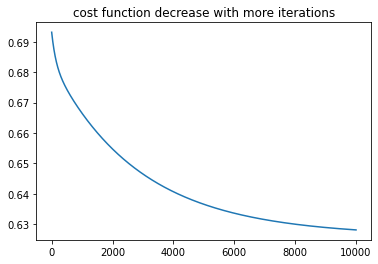

In [178]:
#plot the cost function
import matplotlib.pyplot as plt
from importlib import reload

plt.plot(J_list)
plt.title("cost function decrease with more iterations")
plt.show()

## build the vocabulary of frequencies
1. for all the training dataset, train_x and train_y, use it to build a dic
2. the dic contains {(word, sentiment): ct}

In [122]:
def count_tweets(tweets, y_sentiment):
    '''
    Input:
        tweets: a list of tweets
        y_sentiment: a list corresponding to the sentiment of each tweet (either 0 or 1)
    Output:
        vocabulary: a dictionary mapping each pair to its frequency
    '''
    vocabulary = {}
    for tweet,y in zip(tweets, y_sentiment):
        words = process_tweet(tweet)
        for word in words:
            # define the key, which is the word and label tuple
            pair = (word, y)
            vocabulary[pair] = vocabulary.get(pair,0) + 1
    return vocabulary

In [123]:
#here to build the frequency for all the training x and y for later use
freqs = count_tweets(train_x, train_y)
len(freqs)

11430

## Extracting the Features
1. extract two features from a tweet sentence: 
    - number of words showed up in the positive vocabulary
    - number of words showed up in the negative vocabulary


In [174]:
def extract_features(tweet, freqs):
    '''
    Input: 
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    words = process_tweet(tweet)
    
    # 3 elements for [bias, positive, negative] counts
    x = np.zeros(3) 
    x[0] = 1 
    for word in words:
        x[1] += freqs.get((word, 1.0),0)
        x[2] += freqs.get((word, 0.0),0)
    x = x[None, :]  #from dimension x3 to 1x3
    assert(x.shape == (1, 3))
    return x

In [175]:
# example:
extract_features(train_x[0], freqs)

array([[1.000e+00, 3.133e+03, 6.100e+01]])

## train the model
1. for each train_x, use the feature extraction function to extract to three numbers
2. use it along with train_y label to trian the model

In [185]:
#feature eng all train_x
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)

# training labels corresponding to X
Y = train_y

# Apply gradient descent-adjust the alpha and number iters to get a curve of J list
J, theta,J_list = gradientDescent(x = X, y = Y, theta = np.zeros((3, 1)), alpha = 1e-8, num_iters = 1000)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {theta}")

The cost after training is 0.10158945.
The resulting vector of weights is [[ 3.06161722e-07]
 [ 1.27534877e-03]
 [-1.10909177e-03]]


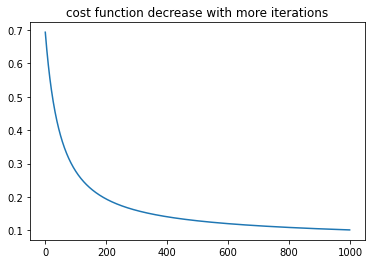

In [186]:
plt.plot(J_list)
plt.title("cost function decrease with more iterations")
plt.show()

## predict
1. Given a tweet, process it, then extract the features.
2. Apply the model's learned weights on the features to get the logits.
3. Apply the sigmoid to the logits to get the prediction (a value between 0 and 1
    - $y_{pred} = sigmoid(\mathbf{x} \cdot \theta)$

In [187]:
def predict_tweet(tweet, freqs, theta):
    '''
    Input: 
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output: 
        y_pred: the probability of a tweet being positive or negative
    '''
    # extract the features
    x = extract_features(tweet, freqs)
    
    # make the prediction using x and theta
    y_pred = sigmoid(np.dot(x,theta))
    return y_pred

In [190]:
tweets = ['I am happy'
          , 'I am bad'
          , 'this movie should have been great.'
          , 'great', 'great great'
          , 'great great great'
          , 'great great great great'
          , 'get out of the house'
          , "what's wrong with you"]
for tweet in tweets:
    print( '%f -> %s' % (predict_tweet(tweet, freqs, theta), tweet))
    

0.546526 -> I am happy
0.489493 -> I am bad
0.539508 -> this movie should have been great.
0.538806 -> great
0.577147 -> great great
0.614580 -> great great great
0.650706 -> great great great great
0.500730 -> get out of the house
0.496242 -> what's wrong with you


## test the model
1. use the above mentioned prediction method, apply to the test dataset
2. compare y_pred with y_test
3. If the prediction is > 0.5, set the model's classification 'y_hat' to 1, otherwise set the model's classification 'y_hat' to 0.
4. A prediction is accurate when the y_hat equals the test_y.  Sum up all the instances when they are equal and divide by m.

In [191]:
def test_logistic_regression(test_x, test_y, freqs, theta):
    """
    Input: 
        test_x: a list of tweets
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: weight vector of dimension (3, 1)
    Output: 
        accuracy: (# of tweets classified correctly) / (total # of tweets)
    """
    y_hat = []
    
    for tweet in test_x:
        y_pred = predict_tweet(tweet, freqs, theta)
        
        if y_pred > 0.5: y_hat.append(1.0)
        else: y_hat.append(0.0)
    accuracy = sum(np.asarray(y_hat) == np.squeeze(test_y))/test_y.shape[0]
    return accuracy

In [192]:
# out of sample test
test_logistic_regression(test_x, test_y, freqs, theta)

0.9945

In [193]:
# in sample test
test_logistic_regression(train_x, train_y, freqs, theta)

0.994875

## Error analysis
1. for the miss classifyed models, print original   
?maybe braindot is not a positive word?

In [198]:
print('Truth Predicted Tweet')
for x,y in zip(test_x, test_y):
    p = predict_tweet(x, freqs, theta)
    y_hat_i = 1.0 if p>0.5 else 0.0
    if y != y_hat_i: 
        print(y, y_hat_i, process_tweet(x))

Truth Predicted Tweet
[1.] 0.0 ["i'm", 'play', 'brain', 'dot', 'braindot']
[1.] 0.0 ["i'm", 'play', 'brain', 'dot', 'braindot']
[1.] 0.0 ["i'm", 'play', 'brain', 'dot', 'braindot']
[1.] 0.0 ['uff', 'itna', 'miss', 'karhi', 'thi', 'ap', ':p']
[0.] 1.0 ['u', 'prob', 'fun', 'david']
[0.] 1.0 ['pat', 'jay']
[0.] 1.0 ['whatev', 'stil', 'l', 'young', '>:-(']
[0.] 1.0 ['belov', 'grandmoth']
[0.] 1.0 ['that', 'life', 'get', 'call', 'peopl', 'havent', 'seen', '20', 'year', 'alway', 'favour']
[0.] 1.0 ['sr', 'financi', 'analyst', 'expedia', 'inc', 'bellevu', 'wa', 'financ', 'expediajob', 'job', 'job', 'hire']
[0.] 1.0 ['midland', 'ye', 'thank', 'depress', 'weather', 'forecast', 'word', 'rain', 'mention', 'sever', 'time', ':-(']
